**Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from joblib import Parallel, delayed
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import scipy as sc
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 300)

In [2]:
data_dir = '../input/optiver-realized-volatility-prediction/'

In [3]:
# Function to calculate first WAP
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

# Function to calculate the log of the return
# Remember that logb(x / y) = logb(x) - logb(y)
def log_return(series):
    return np.log(series).diff()

# Calculate the realized volatility
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

# Function to count unique elements of a series
def count_unique(series):
    return len(np.unique(series))

In [4]:
# Function to read our base train and test set
def read_train_test():
    train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
    # Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print(f'Our training set has {train.shape[0]} rows')
    return train, test

In [5]:
# Function to preprocess book data (for each stock id)
def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    # Dict for aggregations
    create_feature_dict = {
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread':[np.sum, np.mean, np.std],
        'bid_spread':[np.sum, np.mean, np.std],
        'ask_spread':[np.sum, np.mean, np.std],
        'total_volume':[np.sum, np.mean, np.std],
        'volume_imbalance':[np.sum, np.mean, np.std]
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    df_feature_450 = get_stats_window(seconds_in_bucket = 450, add_suffix = True)
    df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
    df_feature_150 = get_stats_window(seconds_in_bucket = 150, add_suffix = True)
    
    # Merge all
    df_feature = df_feature.merge(df_feature_450, how = 'left', left_on = 'time_id_', right_on = 'time_id__450')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_150, how = 'left', left_on = 'time_id_', right_on = 'time_id__150')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__450', 'time_id__300', 'time_id__150'], axis = 1, inplace = True)
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    return df_feature

In [6]:
# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    
    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.mean],
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    df_feature_450 = get_stats_window(seconds_in_bucket = 450, add_suffix = True)
    df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
    df_feature_150 = get_stats_window(seconds_in_bucket = 150, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_450, how = 'left', left_on = 'time_id_', right_on = 'time_id__450')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_150, how = 'left', left_on = 'time_id_', right_on = 'time_id__150')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__450', 'time_id__300', 'time_id__150'], axis = 1, inplace = True)
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    return df_feature

In [7]:
# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
    # Get realized volatility columns
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 'log_return1_realized_volatility_450', 'log_return2_realized_volatility_450', 
                'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 'log_return1_realized_volatility_150', 'log_return2_realized_volatility_150', 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_450', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_150']

    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df

In [8]:
# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids, is_train = True):
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')
        
        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    return df

In [9]:
# Read train and test
train, test = read_train_test()

Our training set has 428932 rows


In [10]:
# Get unique stock ids 
train_stock_ids = train['stock_id'].unique()

In [11]:
# Preprocess them using Parallel and our single stock id functions
train_ = preprocessor(train_stock_ids, is_train = True)
train = train.merge(train_, on = ['row_id'], how = 'left')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 17.3min finished


In [12]:
# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


In [13]:
train.head()

,stock_id,time_id,target,row_id,wap1_sum,wap1_mean,wap1_std,wap2_sum,wap2_mean,wap2_std,log_return1_sum,log_return1_realized_volatility,log_return1_mean,log_return1_std,log_return2_sum,log_return2_realized_volatility,log_return2_mean,log_return2_std,wap_balance_sum,wap_balance_mean,wap_balance_std,price_spread_sum,price_spread_mean,price_spread_std,bid_spread_sum,bid_spread_mean,bid_spread_std,ask_spread_sum,ask_spread_mean,ask_spread_std,total_volume_sum,total_volume_mean,total_volume_std,volume_imbalance_sum,volume_imbalance_mean,volume_imbalance_std,wap1_sum_450,wap1_mean_450,wap1_std_450,wap2_sum_450,wap2_mean_450,wap2_std_450,log_return1_sum_450,log_return1_realized_volatility_450,log_return1_mean_450,log_return1_std_450,log_return2_sum_450,log_return2_realized_volatility_450,log_return2_mean_450,log_return2_std_450,wap_balance_sum_450,wap_balance_mean_450,wap_balance_std_450,price_spread_sum_450,price_spread_mean_450,price_spread_std_450,bid_spread_sum_450,bid_spread_mean_450,bid_spread_std_450,ask_spread_sum_450,ask_spread_mean_450,ask_spread_std_450,total_volume_sum_450,total_volume_mean_450,total_volume_std_450,volume_imbalance_sum_450,volume_imbalance_mean_450,volume_imbalance_std_450,wap1_sum_300,wap1_mean_300,wap1_std_300,wap2_sum_300,wap2_mean_300,wap2_std_300,log_return1_sum_300,log_return1_realized_volatility_300,log_return1_mean_300,log_return1_std_300,log_return2_sum_300,log_return2_realized_volatility_300,log_return2_mean_300,log_return2_std_300,wap_balance_sum_300,wap_balance_mean_300,wap_balance_std_300,price_spread_sum_300,price_spread_mean_300,price_spread_std_300,bid_spread_sum_300,bid_spread_mean_300,bid_spread_std_300,ask_spread_sum_300,ask_spread_mean_300,ask_spread_std_300,total_volume_sum_300,total_volume_mean_300,total_volume_std_300,volume_imbalance_sum_300,volume_imbalance_mean_300,volume_imbalance_std_300,wap1_sum_150,wap1_mean_150,wap1_std_150,wap2_sum_150,wap2_mean_150,wap2_std_150,log_return1_sum_150,log_return1_realized_volatility_150,log_return1_mean_150,log_return1_std_150,log_return2_sum_150,log_return2_realized_volatility_150,log_return2_mean_150,log_return2_std_150,wap_balance_sum_150,wap_balance_mean_150,wap_balance_std_150,price_spread_sum_150,price_spread_mean_150,price_spread_std_150,bid_spread_sum_150,bid_spread_mean_150,bid_spread_std_150,ask_spread_sum_150,ask_spread_mean_150,ask_spread_std_150,total_volume_sum_150,total_volume_mean_150,total_volume_std_150,volume_imbalance_sum_150,volume_imbalance_mean_150,volume_imbalance_std_150,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_450,trade_seconds_in_bucket_count_unique_450,trade_size_sum_450,trade_order_count_mean_450,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,trade_log_return_realized_volatility_150,trade_seconds_in_bucket_count_unique_150,trade_size_sum_150,trade_order_count_mean_150
0,0,5,0.004136,0-5,303.125061,1.003725,0.000693,303.105530,1.003661,0.000781,0.002292,0.004499,7.613697e-06,0.000260,0.002325,0.006999,0.000008,0.000404,0.117051,0.000388,0.000295,0.257255,0.000852,0.000211,0.053006,0.000176,0.000162,-0.045557,-0.000151,0.000126,97696,323.496689,138.101214,40738,134.894040,107.260583,68.236748,1.003482,0.000514,68.231674,1.003407,0.000640,-0.000361,0.001722,-0.000005,0.000210,0.000068,0.004114,0.000001,0.000503,0.024869,0.000366,0.000277,0.053236,0.000783,0.000181,0.017790,0.000262,0.000178,-0.011274,-0.000166,0.000126,17948,263.941176,116.940077,9620,141.470588,84.467864,139.521729,1.003753,0.000487,139.509750,1.003667,0.000585,0.000157,0.002953,1.131361e-06,0.000251,0.000274,0.004864,0.000002,0.000414,0.051757,0.000372,0.000273,0.114272,0.000822,0.000237,0.030976,0.000223,0.000173,-0.022548,-0.000162,0.000131,40995,294.928058,136.527199,19065,137.158273,97.898813,232.888916,1.003832,0.000445,232.870728,1.003753,0.000519,0.000276,0

In [14]:
train.shape

(428932, 148)

In [15]:
# Get group stats of time_id and stock_id
train = get_time_stock(train)
test = get_time_stock(test)

In [16]:
train.shape

(428932, 244)

In [17]:
#stock_id target encoding
train['stock_id'] = train['row_id'].apply(lambda x:x.split('-')[0])
test['stock_id'] = test['row_id'].apply(lambda x:x.split('-')[0])

stock_id_target_mean = train.groupby('stock_id')['target'].mean() 
test['stock_id_target_enc'] = test['stock_id'].map(stock_id_target_mean) # test_set

#training
tmp = np.repeat(np.nan, train.shape[0])
kf = KFold(n_splits = 20, shuffle=True,random_state = 42)
for idx_1, idx_2 in kf.split(train):
    target_mean = train.iloc[idx_1].groupby('stock_id')['target'].mean()

    tmp[idx_2] = train['stock_id'].iloc[idx_2].map(target_mean)
train['stock_id_target_enc'] = tmp

In [18]:
train.shape

(428932, 245)

In [19]:
train['stock_id'] = train['stock_id'].astype(np.int32)

In [20]:
corr_matrix = train.corr()

In [21]:
corr_matrix['target'].sort_values(ascending=False)

target                                 1.000000
log_return1_realized_volatility_150    0.881695
log_return1_realized_volatility_300    0.879109
log_return1_realized_volatility        0.873777
log_return2_realized_volatility_150    0.872967
                                         ...   
ask_spread_sum                        -0.326288
ask_spread_mean_450                   -0.379601
ask_spread_mean_300                   -0.401778
ask_spread_mean_150                   -0.414580
ask_spread_mean                       -0.428284
Name: target, Length: 244, dtype: float64

In [22]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(train, test_size=0.2, random_state=42)

In [23]:
train_labels = train_set["target"].copy()
X_train = train_set.drop(columns = ["target", 'row_id'])
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343145 entries, 346386 to 121958
Columns: 243 entries, stock_id to stock_id_target_enc
dtypes: float32(148), float64(85), int32(9), int64(1)
memory usage: 433.3 MB


In [24]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

In [25]:
X_pipeline = Pipeline([
('imputer', SimpleImputer(strategy="mean")),
('std_scaler', StandardScaler()),
])
X_train_tr = X_pipeline.fit_transform(X_train)

In [26]:
X_train_tr

array([[ 1.06634877, -0.1880904 , -0.25313556, ...,  4.05437572,
         1.68366109,  0.37533744],
       [ 0.04258499,  1.60123907,  0.45489578, ..., -0.12929876,
        -0.54726261, -1.17360979],
       [ 1.30881914,  1.0413201 ,  1.49013039, ..., -0.84511535,
        -0.40645362, -1.0335875 ],
       ...,
       [-0.68482611, -0.18841047, -2.00033263, ..., -0.85930598,
        -1.18586317,  2.14363813],
       [-0.57706151, -0.50016414,  1.51940431, ..., -0.49700423,
        -0.34855935, -1.36102408],
       [-0.76564957,  1.17959277,  0.69146607, ..., -0.90063919,
        -0.73478074, -0.99444192]])

In [27]:
attribs = list(X_train)

full_pipeline = ColumnTransformer([
("num", X_pipeline, attribs)
])
train_prepared = full_pipeline.fit_transform(X_train)

In [28]:
train_prepared

array([[ 1.06634877, -0.1880904 , -0.25313556, ...,  4.05437572,
         1.68366109,  0.37533744],
       [ 0.04258499,  1.60123907,  0.45489578, ..., -0.12929876,
        -0.54726261, -1.17360979],
       [ 1.30881914,  1.0413201 ,  1.49013039, ..., -0.84511535,
        -0.40645362, -1.0335875 ],
       ...,
       [-0.68482611, -0.18841047, -2.00033263, ..., -0.85930598,
        -1.18586317,  2.14363813],
       [-0.57706151, -0.50016414,  1.51940431, ..., -0.49700423,
        -0.34855935, -1.36102408],
       [-0.76564957,  1.17959277,  0.69146607, ..., -0.90063919,
        -0.73478074, -0.99444192]])

In [29]:
train_prepared.shape

(343145, 243)

In [30]:
input_shape = train_prepared.shape[1]
print(input_shape)

243


In [31]:
#x_train = train_prepared.toarray()
#x_train

In [32]:
X_test_set = test_set.drop(columns = ["target", 'row_id'])
X_test_set_prepared = full_pipeline.transform(X_test_set)
test_set_labels = test_set["target"].copy()
#x_test_set = X_test_prepared.toarray()

In [33]:
from lightgbm import LGBMRegressor

# define model
model = LGBMRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=5)

In [34]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [35]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'root_mean_squared_error', 
            "eval_set" : [(X_test_set_prepared, test_set_labels)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100}

In [36]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [37]:
gs = RandomizedSearchCV(
    estimator=model, param_distributions=param_test, 
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=5,
    refit=True,
    random_state=42,
    verbose=True,
    n_jobs=-1,
    pre_dispatch='2*n_jobs')

In [38]:
gs.fit(train_prepared, train_labels, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 31.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 130.7min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 187.9min finished


Training until validation scores don't improve for 30 rounds
[100]	valid's rmse: 0.00112418	valid's l2: 1.26379e-06
[200]	valid's rmse: 0.00107337	valid's l2: 1.15212e-06
[300]	valid's rmse: 0.00105132	valid's l2: 1.10528e-06
[400]	valid's rmse: 0.00103821	valid's l2: 1.07787e-06
[500]	valid's rmse: 0.00102842	valid's l2: 1.05765e-06
[600]	valid's rmse: 0.00102235	valid's l2: 1.04519e-06
[700]	valid's rmse: 0.00101774	valid's l2: 1.03579e-06
[800]	valid's rmse: 0.00101472	valid's l2: 1.02966e-06
[900]	valid's rmse: 0.00101263	valid's l2: 1.02542e-06
[1000]	valid's rmse: 0.00101082	valid's l2: 1.02175e-06
Did not meet early stopping. Best iteration is:
[985]	valid's rmse: 0.00101074	valid's l2: 1.02159e-06
Best score reached: -0.0009987298550726495 with params: {'colsample_bytree': 0.710997791418242, 'min_child_samples': 485, 'min_child_weight': 1e-05, 'num_leaves': 45, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.7619872671896875} 


In [39]:
best_model = gs.best_estimator_

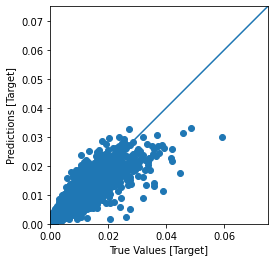

In [40]:
test_set_predictions = best_model.predict(X_test_set_prepared).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_set_labels, test_set_predictions)
plt.xlabel('True Values [Target]')
plt.ylabel('Predictions [Target]')
lims = [0, 0.075]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [41]:
# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

In [42]:
rmspe(test_set_labels, test_set_predictions)

0.23034469193969312

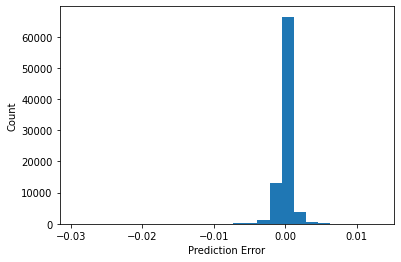

In [43]:
error = test_set_predictions - test_set_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

In [44]:
X_test = test.drop(columns = ['row_id'])

In [45]:
X_test['stock_id'] = X_test['stock_id'].astype(np.int32)

In [46]:
X_test_prepared = full_pipeline.transform(X_test)

In [47]:
#x_test = X_test_prepared.toarray()

In [48]:
final_predictions = best_model.predict(X_test_prepared).flatten()
test['target'] = final_predictions
test.head()

,stock_id,time_id,row_id,wap1_sum,wap1_mean,wap1_std,wap2_sum,wap2_mean,wap2_std,log_return1_sum,log_return1_realized_volatility,log_return1_mean,log_return1_std,log_return2_sum,log_return2_realized_volatility,log_return2_mean,log_return2_std,wap_balance_sum,wap_balance_mean,wap_balance_std,price_spread_sum,price_spread_mean,price_spread_std,bid_spread_sum,bid_spread_mean,bid_spread_std,ask_spread_sum,ask_spread_mean,ask_spread_std,total_volume_sum,total_volume_mean,total_volume_std,volume_imbalance_sum,volume_imbalance_mean,volume_imbalance_std,wap1_sum_450,wap1_mean_450,wap1_std_450,wap2_sum_450,wap2_mean_450,wap2_std_450,log_return1_sum_450,log_return1_realized_volatility_450,log_return1_mean_450,log_return1_std_450,log_return2_sum_450,log_return2_realized_volatility_450,log_return2_mean_450,log_return2_std_450,wap_balance_sum_450,wap_balance_mean_450,wap_balance_std_450,price_spread_sum_450,price_spread_mean_450,price_spread_std_450,bid_spread_sum_450,bid_spread_mean_450,bid_spread_std_450,ask_spread_sum_450,ask_spread_mean_450,ask_spread_std_450,total_volume_sum_450,total_volume_mean_450,total_volume_std_450,volume_imbalance_sum_450,volume_imbalance_mean_450,volume_imbalance_std_450,wap1_sum_300,wap1_mean_300,wap1_std_300,wap2_sum_300,wap2_mean_300,wap2_std_300,log_return1_sum_300,log_return1_realized_volatility_300,log_return1_mean_300,log_return1_std_300,log_return2_sum_300,log_return2_realized_volatility_300,log_return2_mean_300,log_return2_std_300,wap_balance_sum_300,wap_balance_mean_300,wap_balance_std_300,price_spread_sum_300,price_spread_mean_300,price_spread_std_300,bid_spread_sum_300,bid_spread_mean_300,bid_spread_std_300,ask_spread_sum_300,ask_spread_mean_300,ask_spread_std_300,total_volume_sum_300,total_volume_mean_300,total_volume_std_300,volume_imbalance_sum_300,volume_imbalance_mean_300,volume_imbalance_std_300,wap1_sum_150,wap1_mean_150,wap1_std_150,wap2_sum_150,wap2_mean_150,wap2_std_150,log_return1_sum_150,log_return1_realized_volatility_150,log_return1_mean_150,log_return1_std_150,log_return2_sum_150,log_return2_realized_volatility_150,log_return2_mean_150,log_return2_std_150,wap_balance_sum_150,wap_balance_mean_150,wap_balance_std_150,price_spread_sum_150,price_spread_mean_150,price_spread_std_150,bid_spread_sum_150,bid_spread_mean_150,bid_spread_std_150,ask_spread_sum_150,ask_spread_mean_150,ask_spread_std_150,total_volume_sum_150,total_volume_mean_150,total_volume_std_150,volume_imbalance_sum_150,volume_imbalance_mean_150,volume_imbalance_std_150,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_450,trade_seconds_in_bucket_count_unique_450,trade_size_sum_450,trade_order_count_mean_450,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,trade_log_return_realized_volatility_150,trade_seconds_in_bucket_count_unique_150,trade_size_sum_150,trade_order_count_mean_150,log_return1_realized_volatility_mean_stock,log_return1_realized_volatility_std_stock,log_return1_realized_volatility_max_stock,log_return1_realized_volatility_min_stock,log_return2_realized_volatility_mean_stock,log_return2_realized_volatility_std_stock,log_return2_realized_volatility_max_stock,log_return2_realized_volatility_min_stock,log_return1_realized_volatility_450_mean_stock,log_return1_realized_volatility_450_std_stock,log_return1_realized_volatility_450_max_stock,log_return1_realized_volatility_450_min_stock,log_return2_realized_volatility_450_mean_stock,log_return2_realized_volatility_450_std_stock,log_return2_realized_volatility_450_max_stock,log_return2_realized_volatility_450_min_stock,log_return1_realized_volatility_300_mean_stock,log_return1_realized_volatility_300_std_stock,log_return1_realized_volatility_300_max_stock,log_return1_realized_volatility_300_min_stock,log_return2_realized_volatility_300_mean_stock,log_return2_realized_volatility_300_std_stock,l

In [49]:
test[['row_id', 'target']].to_csv('submission.csv',index = False)

In [50]:
test[['row_id', 'target']]

,row_id,target
0,0-4,0.002340
1,0-32,0.003684
2,0-34,0.003684
